In [ ]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.12.0


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving megamillions_07042023.csv to megamillions_07042023.csv


In [ ]:
import io
lotto = pd.read_csv(io.BytesIO(uploaded['megamillions_07042023.csv']), index_col = 'Date')
# Dataset is now stored in a Pandas Dataframe

In [ ]:
print(lotto.shape)
print(list(lotto.columns))

(1419, 6)
['Num1', 'Num2', 'Num3', 'Num4', 'Num5', 'Mega']


In [ ]:
lotto.head()

,Num1,Num2,Num3,Num4,Num5,Mega
Date,,,,,,
02/01/2004,8,7,36,48,44,9
06/01/2004,32,7,15,25,13,9
09/01/2004,49,24,47,32,38,12
13/01/2004,18,21,17,45,3,21
23/01/2004,18,10,33,46,51,13


In [ ]:
lotto.tail()

,Num1,Num2,Num3,Num4,Num5,Mega
Date,,,,,,
24/03/2023,17,14,42,33,66,15
28/03/2023,18,3,68,2,32,24
31/03/2023,26,16,27,42,61,23
04/04/2023,1,45,62,37,64,4
07/04/2023,51,66,49,12,32,21


In [ ]:
data = lotto.values - 1
train = data[:-50]
test = data[-50:]

In [ ]:
w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [ ]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1419, 6)
(1359, 10, 6)
(1359, 6)
(50, 10, 6)
(50, 6)


In [ ]:
embed_dim = (70 // 2)
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 6
feature_count = embed_dim * 6
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [ ]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(70, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(70, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(70, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(70, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(70, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(25, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6])

    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(70, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 6)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                              

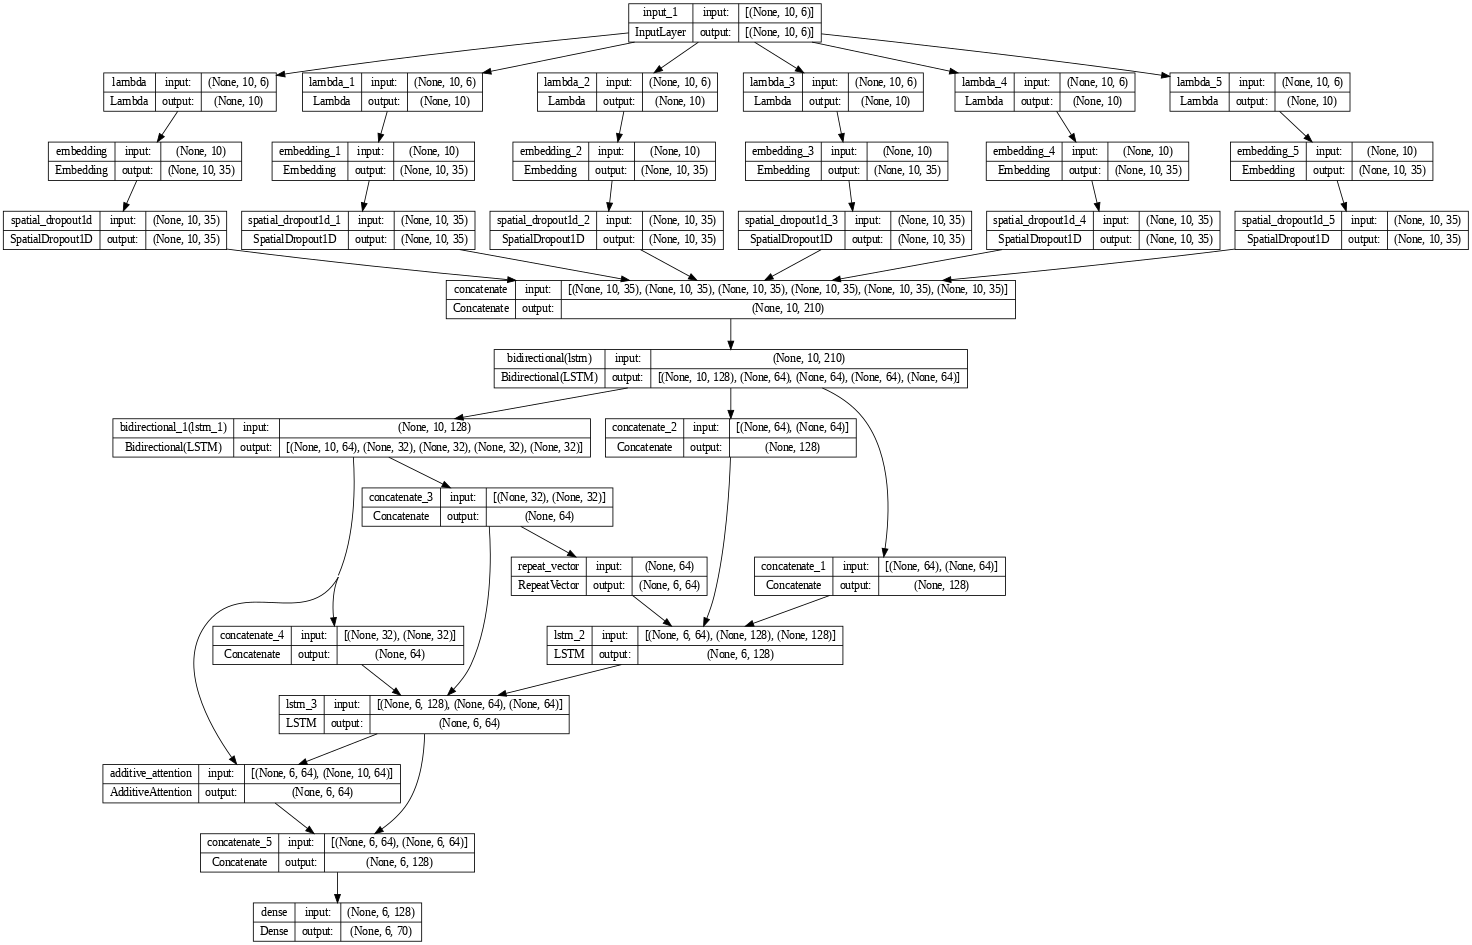

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [ ]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [ ]:
EPOCHS = 200
BATCH_SIZE = 35
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), callbacks = [ckp, cas], epochs = EPOCHS,  batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/200
39/39 - 22s - loss: 4.2475 - sparse_top_k: 0.0801 - val_loss: 4.2470 - val_sparse_top_k: 0.1033 - lr: 1.0000e-04 - 22s/epoch - 566ms/step
Epoch 2/200
39/39 - 2s - loss: 4.2449 - sparse_top_k: 0.0977 - val_loss: 4.2449 - val_sparse_top_k: 0.1067 - lr: 9.9994e-05 - 2s/epoch - 62ms/step
Epoch 3/200
39/39 - 4s - loss: 4.2409 - sparse_top_k: 0.1025 - val_loss: 4.2411 - val_sparse_top_k: 0.1133 - lr: 9.9978e-05 - 4s/epoch - 99ms/step
Epoch 4/200
39/39 - 2s - loss: 4.2321 - sparse_top_k: 0.1029 - val_loss: 4.2294 - val_sparse_top_k: 0.1067 - lr: 9.9950e-05 - 2s/epoch - 57ms/step
Epoch 5/200
39/39 - 2s - loss: 4.2005 - sparse_top_k: 0.1049 - val_loss: 4.2019 - val_sparse_top_k: 0.1167 - lr: 9.9911e-05 - 2s/epoch - 59ms/step
Epoch 6/200
39/39 - 2s - loss: 4.1673 - sparse_top_k: 0.1045 - val_loss: 4.1961 - val_sparse_top_k: 0.0900 - lr: 9.9861e-05 - 2s/epoch - 56ms/step
Epoch 7/200
39/39 - 6s - loss: 4.1550 - sparse_top_k: 0.1089 - val_loss: 4.1885 - val_sparse_top_k: 0.1100 - lr: 9.

0.12666666507720947


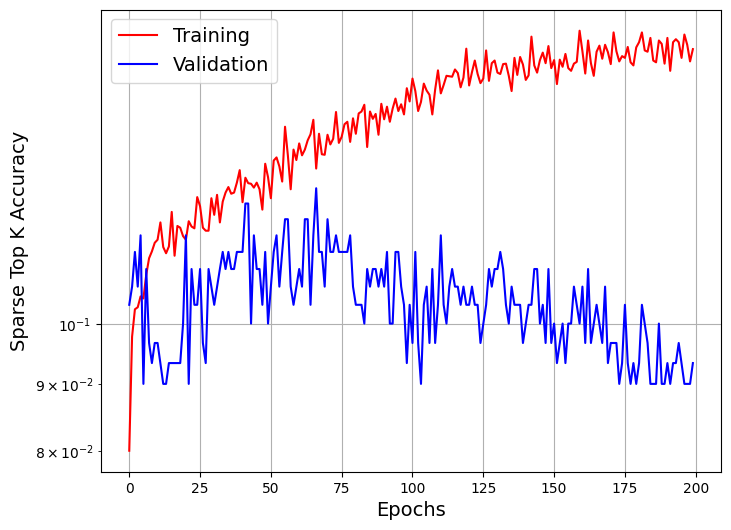

In [ ]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2/2 [==============================] - 3s 15ms/step


In [ ]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [38 38 38 30 11 13]
GoundTruth:	 [15 20 44 67  1 23]
----------------------------------------
Prediction:	 [28 38 38 30 11 13]
GoundTruth:	 [43 36 45 68 34 22]
----------------------------------------
Prediction:	 [38 38 38 30 11 13]
GoundTruth:	 [66 21 45 30 35 21]
----------------------------------------
Prediction:	 [38 38 38 26 11 13]
GoundTruth:	 [18 53 31  4 69  7]
----------------------------------------
Prediction:	 [38 38 38 30 11 13]
GoundTruth:	 [ 9 17 15  5 16 25]
----------------------------------------
Prediction:	 [28 38 38 30 11 13]
GoundTruth:	 [20 55 59  2 47 19]
----------------------------------------
Prediction:	 [38 38 31 31 11 11]
GoundTruth:	 [13 29  5 38 59 23]
----------------------------------------
Prediction:	 [38 31 31 31 11 15]
GoundTruth:	 [17  5 70 37  1 22]
----------------------------------------
Prediction:	 [38 31 31 31 11 15]
GoundTruth:	 [ 6 28 46 19 61 18]
----------------------------------------
Prediction:	 [31 31 31 31 11 15]
Goun

In [ ]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 6)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[15 69 28 25 22 21]
  [60  9 20 59 63  5]
  [55  1 38 23  7  2]
  [39 26 49 29 28 25]
  [21 40 25  1 27 11]
  [17 14 42 33 66 15]
  [18  3 68  2 32 24]
  [26 16 27 42 61 23]
  [ 1 45 62 37 64  4]
  [51 66 49 12 32 21]]]


In [ ]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [ ]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy+1)

1/1 [==============================] - 0s 28ms/step
[38 31 31 31 11 15]


In [ ]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [38 31 31 31 11 15] 	Log Likelihood:  -21.712227769063528
Prediction:  [38 38 31 31 11 15] 	Log Likelihood:  -21.724830446777656
Prediction:  [38 31 31 31 11  9] 	Log Likelihood:  -21.74280619191814
Prediction:  [35 31 31 31 11 15] 	Log Likelihood:  -21.744262346813677
Prediction:  [31 31 31 31 11 15] 	Log Likelihood:  -21.75276001236916
Prediction:  [46 31 31 31 11 15] 	Log Likelihood:  -21.75479300654987
Prediction:  [38 38 31 31 11  9] 	Log Likelihood:  -21.75540886963227
Prediction:  [38 31 31 31 11 13] 	Log Likelihood:  -21.755775342253674
Prediction:  [35 38 31 31 11 15] 	Log Likelihood:  -21.756865024527805
Prediction:  [38 31 31 31 11  6] 	Log Likelihood:  -21.75829669336162


In [ ]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [35 38 26 31 11 15] 	Log Likelihood:  -21.83429109957445
Prediction:  [35 38 26 31 11  9] 	Log Likelihood:  -21.864869522429064
Prediction:  [35 38 31 26 11 15] 	Log Likelihood:  -21.866995250987618
Prediction:  [46 38 31 26 11 15] 	Log Likelihood:  -21.87752591072381
Prediction:  [35 38 26 31 11 13] 	Log Likelihood:  -21.877838672764597
Prediction:  [35 38 26 31 11  6] 	Log Likelihood:  -21.88036002387254
Prediction:  [35 38 26 31 11 10] 	Log Likelihood:  -21.886249915120718
Prediction:  [35 38 26 31 11  1] 	Log Likelihood:  -21.886262548107943
Prediction:  [35 38 26 31 14 15] 	Log Likelihood:  -21.887191506649433
Prediction:  [35 38 31 26 11  9] 	Log Likelihood:  -21.89757367384223


In [ ]:
53 54 31 55 35 24

SyntaxError: ignored